In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

# 중복 있는 Tag

In [3]:
df_tag = pd.read_csv('./Tag.csv', index_col='Unnamed: 0')
df_tag

,testId,Tag
0,A010000001,"5844,5844,5844,5844,5844"
1,A010000002,"5844,5844,5844,6803,6803"
2,A010000003,"6307,6804,6804,6806,6806"
3,A010000004,"5845,5845,6804,6806,6806"
4,A010000005,"5846,6308,6308,6308,6308"
...,...,...
1532,A090000070,"2647,9925,9925,9926,9929,9929,9929,9929"
1533,A090000071,"2644,2647,2647,9924,9924,9926,9929,9929"
1534,A090000072,"2648,4243,4243,4243,4243,4243"
1535,A090000073,"2648,2648,2648,4243,10196,10196"


In [4]:
df_tag['Tag'] = df_tag['Tag'].apply(lambda x: x.replace(',', ' '))
df_tag

,testId,Tag
0,A010000001,5844 5844 5844 5844 5844
1,A010000002,5844 5844 5844 6803 6803
2,A010000003,6307 6804 6804 6806 6806
3,A010000004,5845 5845 6804 6806 6806
4,A010000005,5846 6308 6308 6308 6308
...,...,...
1532,A090000070,2647 9925 9925 9926 9929 9929 9929 9929
1533,A090000071,2644 2647 2647 9924 9924 9926 9929 9929
1534,A090000072,2648 4243 4243 4243 4243 4243
1535,A090000073,2648 2648 2648 4243 10196 10196


## TFIDF 벡터화

In [5]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_tag['Tag'])

### K-means

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 10.49it/s]


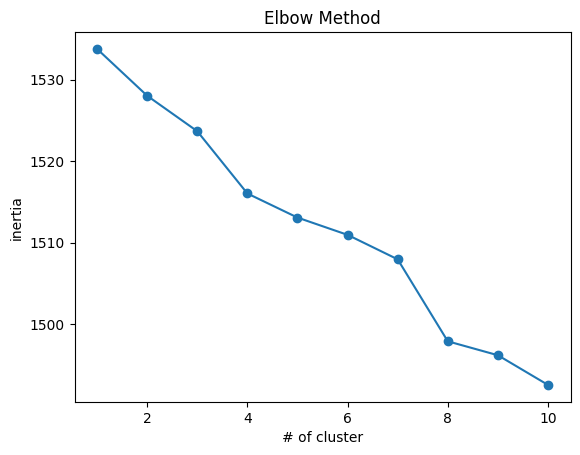

In [6]:
# 스케일링 파이프라인 설정
scaler = MaxAbsScaler()
pipeline = make_pipeline(vectorizer, scaler)

# 클러스터 개수에 따른 응집도를 저장할 리스트
inertia = []

# 클러스터 개수를 1부터 10까지 변경하면서 K-means 모델을 학습하고 응집도를 계산
for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    pipeline.fit_transform(df_tag['Tag'])
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Elbow Method를 통해 적절한 클러스터 개수 찾기
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('# of cluster')
plt.ylabel('inertia')
plt.title('Elbow Method')
plt.show()


100%|█████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.30it/s]


최적의 클러스터 개수: 9


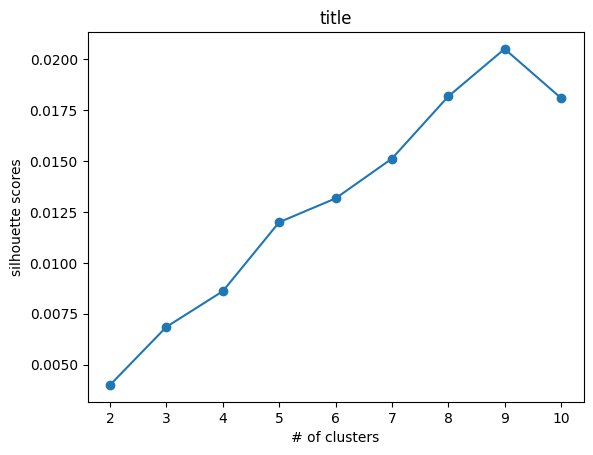

In [7]:
# 클러스터 개수에 따른 실루엣 점수를 저장할 리스트
silhouette_scores = []

# 클러스터 개수를 2부터 10까지 변경하면서 K-means 모델을 학습하고 실루엣 점수를 계산
for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    pipeline.fit_transform(df_tag['Tag'])
    kmeans.fit(X)
    
    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# 실루엣 점수를 통해 적절한 클러스터 개수 찾기
best_k = silhouette_scores.index(max(silhouette_scores)) + 2  # 실루엣 점수가 가장 높은 클러스터 개수
print(f"최적의 클러스터 개수: {best_k}")

# 클러스터 개수에 따른 실루엣 점수를 그래프로 표시
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('silhouette scores')
plt.title('title')
plt.show()

In [8]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters=9, random_state=42)
pipeline.fit_transform(df_tag['Tag'])
kmeans.fit(X)

# 각 텍스트의 클러스터 할당 결과
df_tag['cluster'] = kmeans.labels_

# 결과 출력
print(df_tag[['Tag', 'cluster']])

                                          Tag  cluster
0                    5844 5844 5844 5844 5844        0
1                    5844 5844 5844 6803 6803        0
2                    6307 6804 6804 6806 6806        0
3                    5845 5845 6804 6806 6806        0
4                    5846 6308 6308 6308 6308        0
...                                       ...      ...
1532  2647 9925 9925 9926 9929 9929 9929 9929        0
1533  2644 2647 2647 9924 9924 9926 9929 9929        0
1534            2648 4243 4243 4243 4243 4243        0
1535          2648 2648 2648 4243 10196 10196        0
1536           2648 2648 4243 4243 4243 10196        0

[1537 rows x 2 columns]


In [9]:
df_tag['cluster'].value_counts().sort_index()

cluster
0    1471
1      15
2       3
3       3
4      14
5       6
6      12
7      10
8       3
Name: count, dtype: int64

### hierarchical clustering

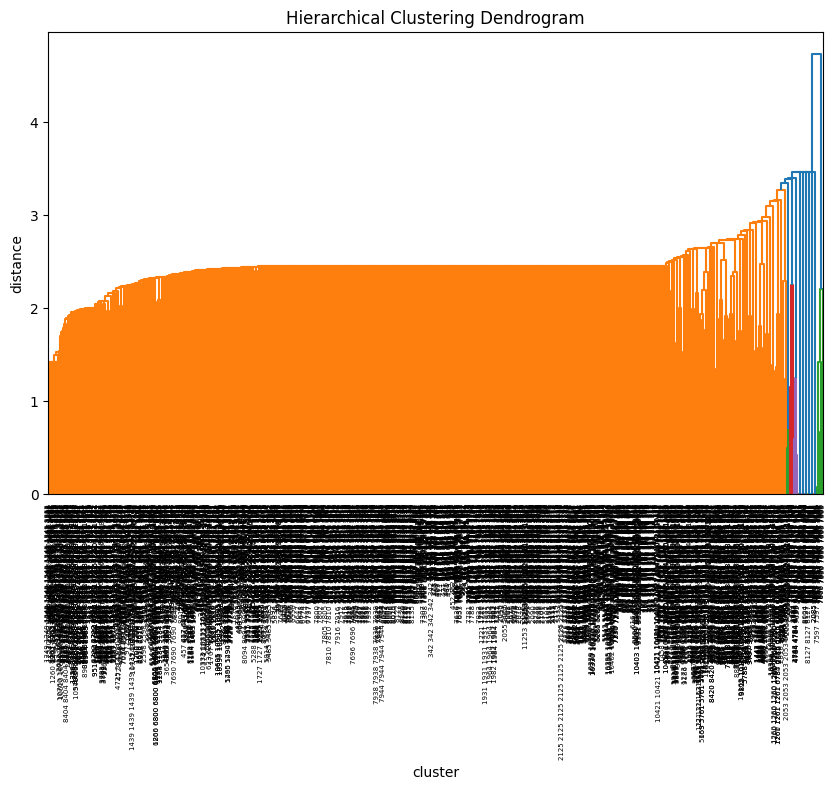

In [10]:
# linkage를 사용하여 hierarchical clustering 수행
linkage_matrix = linkage(X.toarray(), method='ward')  # ward linkage를 사용하며, 다른 linkage 방법도 사용 가능

# 덴드로그램을 통한 시각화
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=df_tag['Tag'].tolist(), orientation='top', distance_sort='descending', show_leaf_counts=True)#, truncate_mode='lastp', p=9)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cluster')
plt.ylabel('distance')
plt.show()

## Word2Vec

In [11]:
# Word2Vec 모델 학습
sentences = [text.split() for text in df_tag['Tag']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=4, min_count=1, workers=4)
                        #vector_size : 임베딩 차원 // window = 주변 몇 단어까지 볼 것인가?
                        #min_count = 1개보다 낮은 빈도의 단어 무시(전체 단어 다 고려하겠다는 뜻)
                        #workers = 모델 학습에 사용할 cpu 코어 수

# 각 문서의 벡터 구성
document_vectors = []
for sentence in sentences:
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if vectors:
        document_vectors.append(sum(vectors) / len(vectors))
    else:
        document_vectors.append([0] * word2vec_model.vector_size)

### K-means

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 25.70it/s]


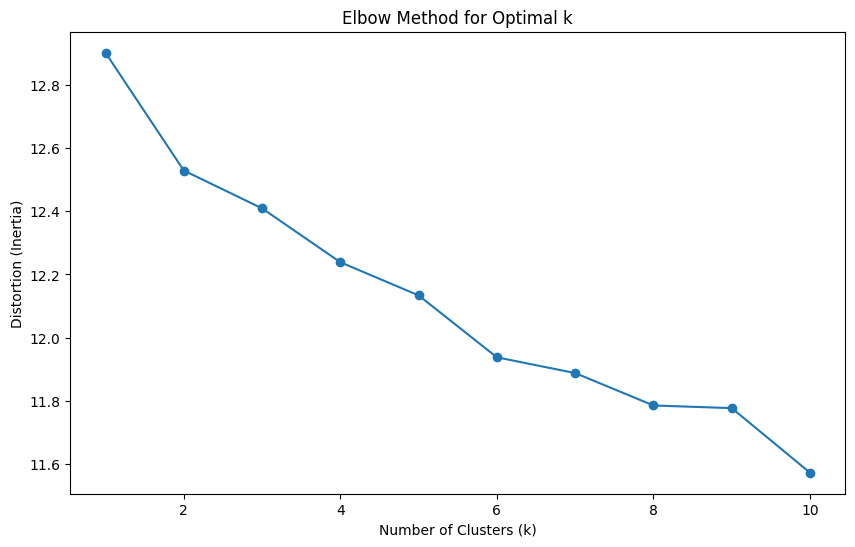

In [12]:
# K-means 클러스터링 및 Elbow Point 찾기
distortions = []

for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(document_vectors)
    distortions.append(kmeans.inertia_)

# Elbow Point 찾기
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

100%|█████████████████████████████████████████████████| 9/9 [00:00<00:00, 12.98it/s]


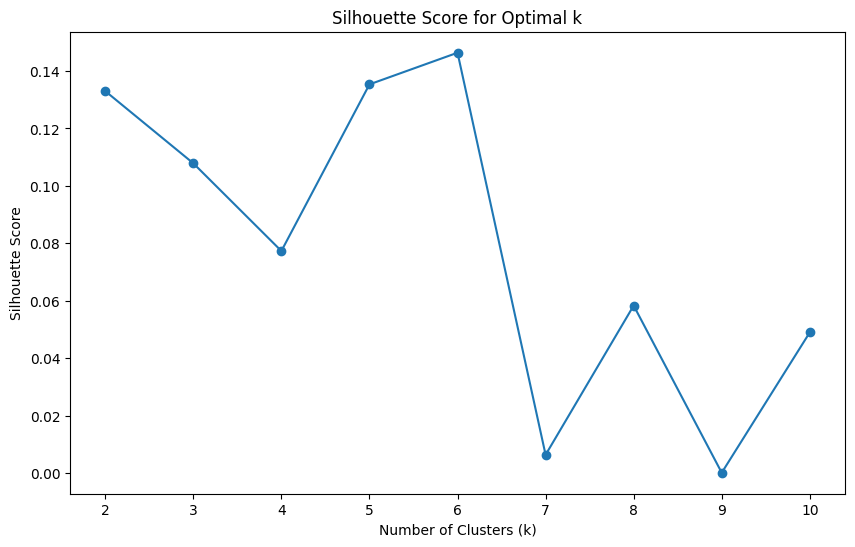

In [13]:
silhouette_scores = []
K = range(2, 11)  # 시도할 클러스터 개수의 범위를 지정

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(document_vectors)
    silhouette_avg = silhouette_score(document_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Silhouette Score를 시각화
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

In [14]:
# K-means 클러스터링
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(document_vectors)

# 클러스터링 결과를 데이터프레임에 추가
df_tag['w2v_cluster'] = cluster_labels

# 결과 출력
print(df_tag[['Tag', 'w2v_cluster']])

                                          Tag  w2v_cluster
0                    5844 5844 5844 5844 5844            1
1                    5844 5844 5844 6803 6803            1
2                    6307 6804 6804 6806 6806            1
3                    5845 5845 6804 6806 6806            1
4                    5846 6308 6308 6308 6308            1
...                                       ...          ...
1532  2647 9925 9925 9926 9929 9929 9929 9929            1
1533  2644 2647 2647 9924 9924 9926 9929 9929            1
1534            2648 4243 4243 4243 4243 4243            1
1535          2648 2648 2648 4243 10196 10196            1
1536           2648 2648 4243 4243 4243 10196            1

[1537 rows x 2 columns]


In [15]:
df_tag['w2v_cluster'].value_counts().sort_index()

w2v_cluster
0       6
1    1192
2     125
3       6
4      15
5     193
Name: count, dtype: int64

### Hierarchical clustering

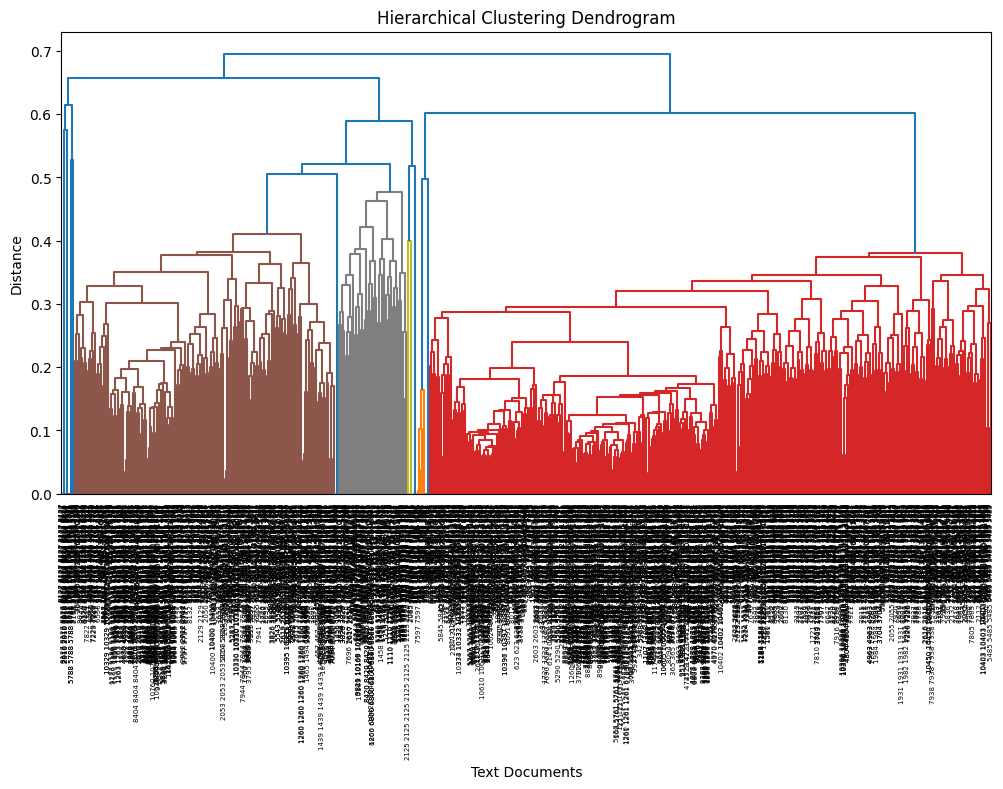

In [16]:
# Hierarchical Clustering
linkage_matrix = linkage(document_vectors, method='ward')

# Dendrogram 시각화
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df_tag['Tag'].tolist(), orientation='top', distance_sort='descending', show_leaf_counts=True)#, truncate_mode='lastp', p=9)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Text Documents')
plt.ylabel('Distance')
plt.show()

# 중복 없는 Tag

In [4]:
df_tag = pd.read_csv('./Tag_deduplication.csv', index_col='Unnamed: 0')
df_tag

,testId,Tag
0,A010000001,5844
1,A010000002,"5844,6803"
2,A010000003,"6307,6804,6806"
3,A010000004,"5845,6804,6806"
4,A010000005,"5846,6308"
...,...,...
1532,A090000070,"2647,9925,9926,9929"
1533,A090000071,"2644,2647,9924,9926,9929"
1534,A090000072,"2648,4243"
1535,A090000073,"2648,4243,10196"


In [5]:
df_tag['Tag'] = df_tag['Tag'].apply(lambda x: x.replace(',', ' '))
df_tag

,testId,Tag
0,A010000001,5844
1,A010000002,5844 6803
2,A010000003,6307 6804 6806
3,A010000004,5845 6804 6806
4,A010000005,5846 6308
...,...,...
1532,A090000070,2647 9925 9926 9929
1533,A090000071,2644 2647 9924 9926 9929
1534,A090000072,2648 4243
1535,A090000073,2648 4243 10196


## TFIDF 벡터화

In [6]:
# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_tag['Tag'])

### K-means

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 10.98it/s]


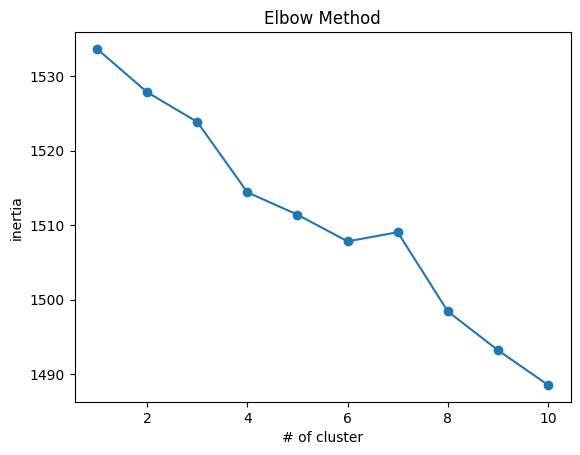

In [7]:
# 스케일링 파이프라인 설정
scaler = MaxAbsScaler()
pipeline = make_pipeline(vectorizer, scaler)

# 클러스터 개수에 따른 응집도를 저장할 리스트
inertia = []

# 클러스터 개수를 1부터 10까지 변경하면서 K-means 모델을 학습하고 응집도를 계산
for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    pipeline.fit_transform(df_tag['Tag'])
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Elbow Method를 통해 적절한 클러스터 개수 찾기
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('# of cluster')
plt.ylabel('inertia')
plt.title('Elbow Method')
plt.show()

100%|█████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.88it/s]


최적의 클러스터 개수: 10


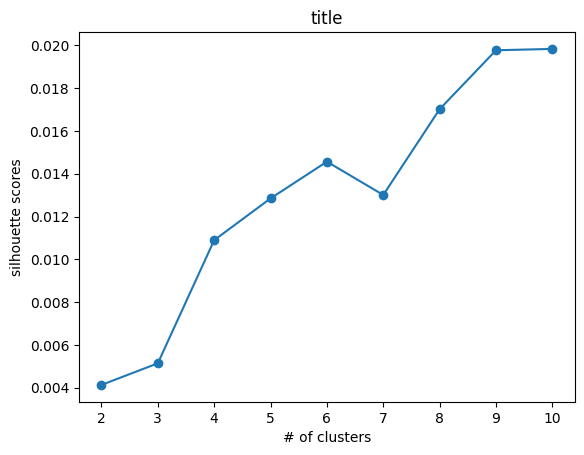

In [8]:
# 클러스터 개수에 따른 실루엣 점수를 저장할 리스트
silhouette_scores = []

# 클러스터 개수를 2부터 10까지 변경하면서 K-means 모델을 학습하고 실루엣 점수를 계산
for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    pipeline.fit_transform(df_tag['Tag'])
    kmeans.fit(X)
    
    # 실루엣 점수 계산
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# 실루엣 점수를 통해 적절한 클러스터 개수 찾기
best_k = silhouette_scores.index(max(silhouette_scores)) + 2  # 실루엣 점수가 가장 높은 클러스터 개수
print(f"최적의 클러스터 개수: {best_k}")

# 클러스터 개수에 따른 실루엣 점수를 그래프로 표시
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('# of clusters')
plt.ylabel('silhouette scores')
plt.title('title')
plt.show()

In [12]:
# K-means 모델 생성 및 학습
kmeans = KMeans(n_clusters=10, random_state=42)
pipeline.fit_transform(df_tag['Tag'])
kmeans.fit(X)

# 각 텍스트의 클러스터 할당 결과
df_tag['cluster'] = kmeans.labels_

# 결과 출력
print(df_tag[['Tag', 'cluster']])

                           Tag  cluster
0                         5844        1
1                    5844 6803        1
2               6307 6804 6806        1
3               5845 6804 6806        1
4                    5846 6308        1
...                        ...      ...
1532       2647 9925 9926 9929        1
1533  2644 2647 9924 9926 9929        1
1534                 2648 4243        1
1535           2648 4243 10196        1
1536           2648 4243 10196        1

[1537 rows x 2 columns]


In [13]:
df_tag['cluster'].value_counts().sort_index()

cluster
0       3
1    1450
2       9
3      12
4       6
5      10
6      14
7      15
8       6
9      12
Name: count, dtype: int64

### Hierarchical Clustering

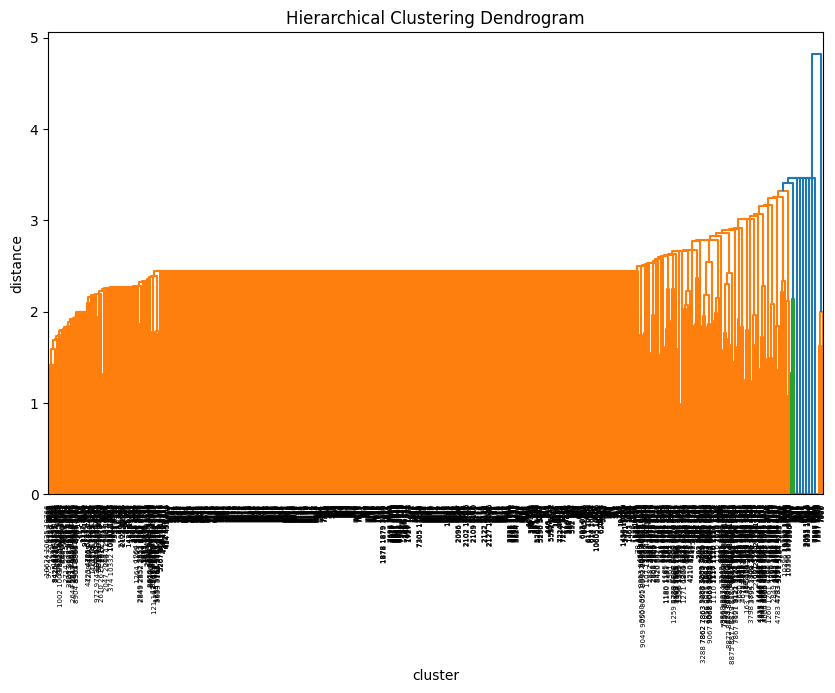

In [15]:
# linkage를 사용하여 hierarchical clustering 수행
linkage_matrix = linkage(X.toarray(), method='ward')  # ward linkage를 사용하며, 다른 linkage 방법도 사용 가능

# 덴드로그램을 통한 시각화
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=df_tag['Tag'].tolist(), orientation='top', distance_sort='descending', show_leaf_counts=True)#, truncate_mode='lastp', p=9)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cluster')
plt.ylabel('distance')
plt.show()

## Word2Vec

In [16]:
# Word2Vec 모델 학습
sentences = [text.split() for text in df_tag['Tag']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=4, min_count=1, workers=4)
                        #vector_size : 임베딩 차원 // window = 주변 몇 단어까지 볼 것인가?
                        #min_count = 1개보다 낮은 빈도의 단어 무시(전체 단어 다 고려하겠다는 뜻)
                        #workers = 모델 학습에 사용할 cpu 코어 수

# 각 문서의 벡터 구성
document_vectors = []
for sentence in sentences:
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    if vectors:
        document_vectors.append(sum(vectors) / len(vectors))
    else:
        document_vectors.append([0] * word2vec_model.vector_size)

### K-means

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 27.14it/s]


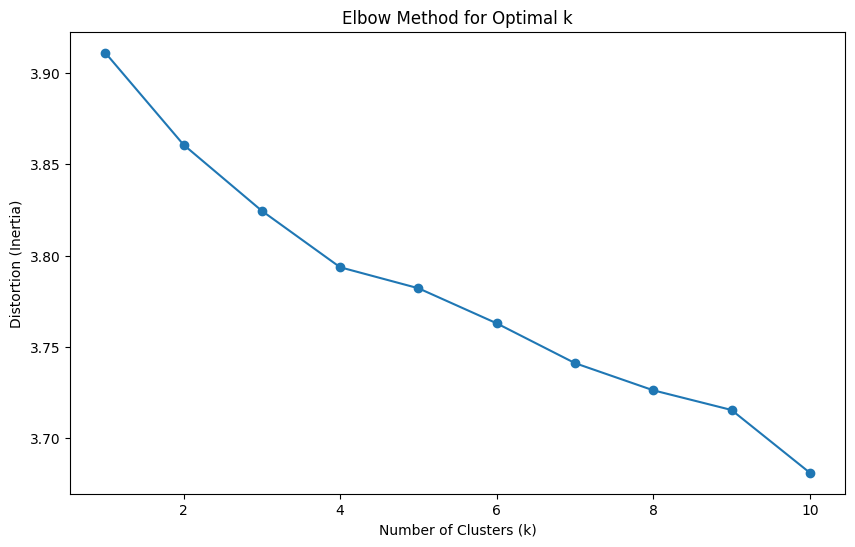

In [17]:
# K-means 클러스터링 및 Elbow Point 찾기
distortions = []

for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(document_vectors)
    distortions.append(kmeans.inertia_)

# Elbow Point 찾기
plt.figure(figsize=(10,6))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

100%|█████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.08it/s]


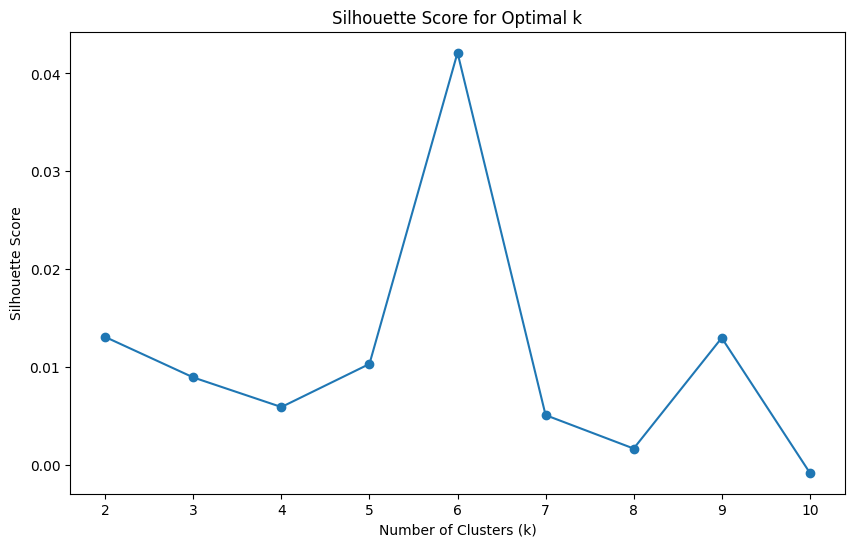

In [18]:
silhouette_scores = []
K = range(2, 11)  # 시도할 클러스터 개수의 범위를 지정

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(document_vectors)
    silhouette_avg = silhouette_score(document_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Silhouette Score를 시각화
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

In [19]:
# K-means 클러스터링
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(document_vectors)

# 클러스터링 결과를 데이터프레임에 추가
df_tag['w2v_cluster'] = cluster_labels

# 결과 출력
print(df_tag[['Tag', 'w2v_cluster']])

                           Tag  w2v_cluster
0                         5844            4
1                    5844 6803            4
2               6307 6804 6806            2
3               5845 6804 6806            2
4                    5846 6308            2
...                        ...          ...
1532       2647 9925 9926 9929            2
1533  2644 2647 9924 9926 9929            2
1534                 2648 4243            2
1535           2648 4243 10196            2
1536           2648 4243 10196            2

[1537 rows x 2 columns]


In [20]:
df_tag['w2v_cluster'].value_counts().sort_index()

w2v_cluster
0      35
1     133
2    1042
3      79
4     175
5      73
Name: count, dtype: int64

### Hierarchical Clustering

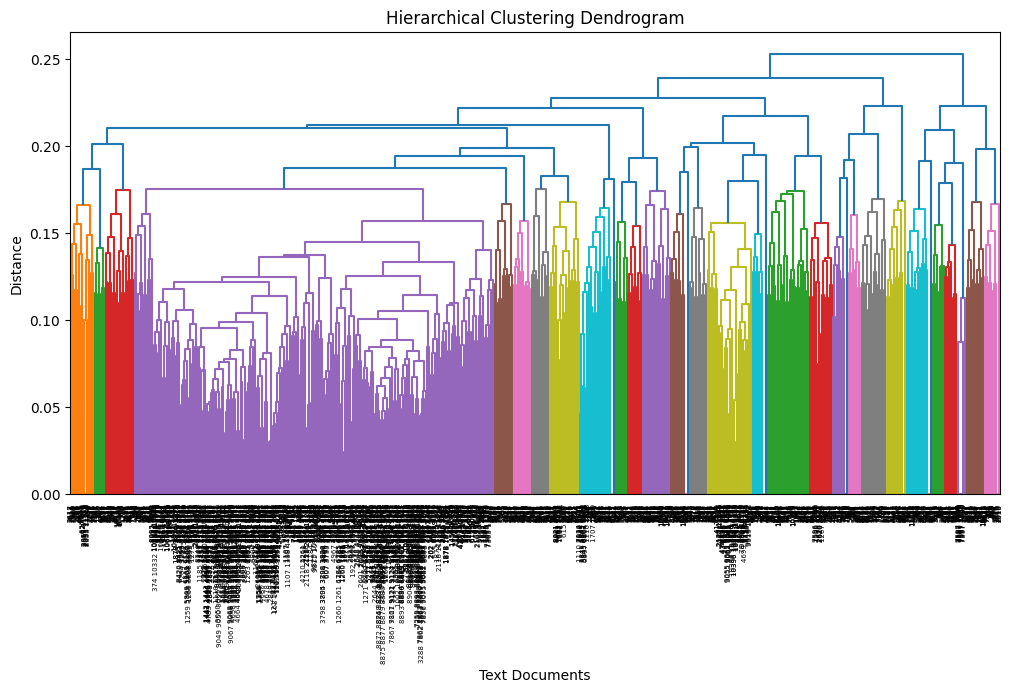

In [21]:
# Hierarchical Clustering
linkage_matrix = linkage(document_vectors, method='ward')

# Dendrogram 시각화
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=df_tag['Tag'].tolist(), orientation='top', distance_sort='descending', show_leaf_counts=True)#, truncate_mode='lastp', p=9)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Text Documents')
plt.ylabel('Distance')
plt.show()